# Stat Models for Laboredge

In [2]:
import os
import sys
import re
import inspect
import pandas as pd
import numpy as np
import pickle

Adding project folder to system path to import modules from Util folder

In [3]:
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
util_dir = os.path.dirname(os.path.dirname(currentdir))

sys.path.insert(0,util_dir)

In [4]:
from util import nlp, db

## Clustering Jobs

### Import Data

In [6]:
conn = db.open_conn(is_prod=True)
labor = db.get_table_pd("SELECT * FROM dbo.v_Services", conn)

In [7]:
labor = nlp.str_impute_lower(labor, labor.columns[labor.dtypes == 'string'])

In [8]:
with open('pickles/labor_pkl.txt', 'wb') as fh:
    pickle.dump(labor, fh)

In [3]:
labor = pd.read_pickle('pickles/labor_pkl.txt')

### Supplier Tiers 

In [17]:
sup_tier = pd.read_excel("tiers.xlsx", sheet_name="std")

In [27]:
sup_tier.supplier = [s.lower() for s in sup_tier.supplier]

In [37]:
set(labor['service provider'])

{'24/7.ai',
 '7summits',
 'ab initio',
 'abb software',
 'accenture',
 'accutive',
 'aci worldwide',
 'active cyber',
 'adobe',
 'adroit resources',
 'adt',
 'advent',
 'aeritae',
 'aftia solutions',
 'agiloft',
 'aim consulting',
 'aipl holdings',
 'alight',
 'allegis global solutions',
 'amazon',
 'amida',
 'anaplan',
 'anark',
 'anglepoint group',
 'apex systems',
 'appian',
 'appirio',
 'apple',
 'appriss',
 'aptos',
 'arista',
 'aronson',
 'asmgi',
 'aspire',
 'assimilate consulting',
 'asynchrony',
 'at kearney',
 'at&t',
 'ataccama',
 'atg',
 'atos',
 'atrium',
 'atscale',
 'audio visual innovations',
 'audiocodes',
 'avanade',
 'avengers consulting group',
 'aveva',
 'avoka',
 'axiom',
 'axis technologies',
 'backbase',
 'bailiwick services',
 'bamboo rose',
 'bankmobile',
 'banyan technology',
 'basis one',
 'basware',
 'bayside resources',
 'bdiplus',
 'beeline',
 'bishop fox',
 'blackbox',
 'blackhall and pearl',
 'blue spire',
 'blue yonder (jda)',
 'bluefletch',
 'bluerast

### Dummy Variables

#### From Position Title

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(labor['full position title'])

In [11]:
count_title = pd.DataFrame(data=X.todense(),columns=cv.get_feature_names())

In [10]:
count_title.sum().nlargest(30).index

Index(['level', 'senior', 'engineer', 'analyst', 'data', 'architect',
       'manager', 'development', 'developer', 'lead', 'management',
       'consultant', 'sr', 'business', 'junior', 'application', 'project',
       'service', 'security', 'support', 'information', 'technical',
       'engineering', 'jr', 'desktop', 'mid', 'infrastructure', 'analytics',
       'virtual', 'software'],
      dtype='object')

In [12]:
title_dum = count_title.sum().nlargest(30).index

In [13]:
for col in title_dum:
    labor[col] = count_title[col]

#### Country, OEM, Service Provider 

__ATTN__ : Leave out one Dummy variable for each category to avoid Colinearity of columns
- country leave out blanks
- supplier leave out first dummy (no blanks)

In [14]:
labor.country = labor.country.replace('usa ','usa')

In [15]:
country_dum = pd.get_dummies(labor.country.replace('',np.nan))
supplier_dum = pd.get_dummies(labor['service provider'])

In [16]:
all_dum = pd.concat([labor[title_dum],country_dum,supplier_dum.iloc[:,1:]],axis=1)

__Problem with using 'Full_Position_Title'__:
- Term Frequency is not useful in short job titles. Varies widely
- multiple variations of same word (sr, senior) count as different words
- Stem of words better than lemmatization?

### Centering, Standardizing Price Quotes

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
scaler = StandardScaler()

In [19]:
quoted_scaled =scaler.fit_transform(np.array(labor['quoted rate low']).reshape(-1,1)).reshape(len(labor))

In [20]:
all_dum['quoted_low_scaled'] = quoted_scaled

### Clustering

In [21]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [22]:
def get_sil_scores(data, clusters):
    sil_scores=[]
    for n_clus in clusters:
        km = KMeans(random_state=0,n_clusters=n_clus)
        km.fit(data)
        score = silhouette_score(data,km.labels_)
        sil_scores.append(score)
    return sil_scores

In [23]:
clusters =[7,8,9,10,11,12,13,14]

In [24]:
sil_scores = get_sil_scores(all_dum.dropna().values,[7,8,9,10,11,12,13,14])
sil_scores

[0.0989157485669578,
 0.08952006001954503,
 0.10073341531235155,
 0.10541332090299978,
 0.10631924957493091,
 0.10628196075151089,
 0.09786268595593967,
 0.09373793175255977]

In [5]:
with open('pickles/labor_pkl.txt', 'wb') as fh:
   pickle.dump(labor, fh)

In [25]:
import matplotlib.pyplot as plt

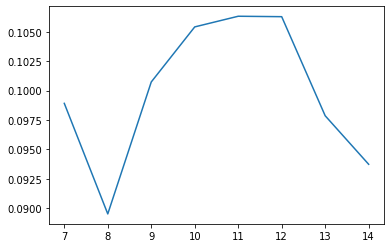

In [26]:
plt.plot(clusters,sil_scores)
plt.show()

In [99]:
km = KMeans(random_state=0, n_clusters = 20)
km.fit(all_dum.dropna().values)


KMeans(n_clusters=20, random_state=0)

In [100]:
pd.Series(km.labels_).value_counts()

1     2772
2     2568
6     2426
11    2414
17    1502
13    1372
18    1099
10    1094
3      994
0      925
7      830
15     814
5      800
9      798
12     739
14     677
8      662
4      604
16     558
19     194
dtype: int64

In [101]:
silhouette_score(all_dum.dropna().values, km.labels_)

0.10347873681898574

__Next Steps:__
- PCA for TFIDF Vectors
    - No interpretability...
- Normalize price columns
- Set Dummy Variables
- Find Cluster Alg
- Silhouette Score

In [88]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(all_dum.dropna().values)
print(pca.explained_variance_ratio_)

[0.23600809 0.0584846  0.04105878]
